In [23]:
#### need to module load python/2.7-anaconda
from astropy.io import fits
from scipy import misc
import numpy as np
import os
import matplotlib 
from matplotlib import pyplot as plt
import pickle, gzip
import h5py

# Debbie Dirs 
dataurl_deb = "/global/homes/d/djbard/project_lsst/m-series/m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.798/"

# Dir urls on srcatch and local host for m-series z=2 
dataurl_from_scratch_dir = "/global/cscratch1/sd/ssingh79/m-series/m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.798/"
dataurl_from_local_dir = "/Users/ssingh79/Downloads/DeepLearningTutorials-master/data/m-series/m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.798/"
dataurl_from_homes_dir = "/global/homes/s/ssingh79/data/"
base_filename = "fico_0200z_conv_"

ouptut_data_dir = ""

def create_png_from_fits():
    for i in range(1,1001):
        if i<10:
            num = "000"+str(i)
        elif i<100:
            num="00"+str(i)
        elif i<1000:
            num = "0"+str(i)
        elif i==1000:
            num = str(i)
        else:
            print("gah!") 
              
        filepath = os.path.join(dataurl_from_local_dir,base_filename + str(num) + ".fit")
        #print(filepath)
        hdulist = fits.open(filepath)

        image = hdulist[0].data
        
        # I'm using the max/min pixel values -0.102/1.6, so that I'm making a consistent greyscale across the cosmologies. This covers everything at z=2. 
        misc.toimage(image, cmin=-0.102, cmax=1.6).save("fico-gifs/fico_0200z_conv_"+num+".png", )

def create_numpy_from_fits(): 

    # Create a numpy array to store images (numpy ndarray)
    # Initialize space for the numpy ndarray 
    image_dim = 1024*1024
    sample_size = 1000
    #flatten_images = np.zeros((sample_size, image_dim), dtype= 'float')
    
    flatten_images = np.zeros((1,1024*1024))
    
    for i in range(1,1001):
        if i<10:
            num = "000"+str(i)
        elif i<100:
            num="00"+str(i)
        elif i<1000:
            num = "0"+str(i)
        elif i==1000:
            num = str(i)
        else:
            print("gah!") 
                  
        filepath = os.path.join(dataurl_from_homes_dir, base_filename + num + ".fit")
        #print(filepath)
        hdulist = fits.open(filepath)

        image = hdulist[0].data
        # Check type of values
        #print(image)
        #print(image.shape)
        #print(image.dtype)
            
        reshaped_image = np.reshape(image,(1,1024*1024))
        #print(reshaped_image)
        
        #image is a temporary numpy array which is to copied in every iteration as a row in flatten_image
        #image has dimension 1024 X 1024 its a 2D array, You want to reshape it to just a row!
        # After which you need to append.
    
        flatten_images = np.vstack((flatten_images , reshaped_image))
        #print(flatten_images)
        print("exiting Iteration", i)
    
    #Delete the first row initialization with 0 done before. 
    flatten_images = np.delete(flatten_images,(0),axis=0)
    
    print(flatten_images)
    print(flatten_images.shape)
    
    #Find the mean, min and max values in the dataset. 
    print("Mean = ", np.mean(flatten_images))
    print("Min = ", np.min(flatten_images))
    print("Max = " , np.max(flatten_images))
    
    #Visulaize the very last image in the dataset. 
    #%matplotlib inline
    #plt.imshow(image,interpolation='None')
    #plt.colorbar()
    
    return flatten_images

def normalize_data():
    #This normalizes the data between [-1, 1]
    # A two step process which includes calculating the mean difference and then normalizing by 
    # known standard formulae. 
    flattened_images = create_numpy_from_fits()
    data_min = np.min(flattened_images) 
    data_max = np.max(flattened_images) 
    data_mean = np.mean(flattened_images) 
    
    print(np.mean(flattened_images))
    print(np.min(flattened_images))
    print(np.max(flattened_images))

def create_h5py_dataset():
    
    flattened_images = create_numpy_from_fits()
    
    # Create h5py data files 
    with h5py.File('/global/homes/s/ssingh79/data/conv_z02.h5','w') as hf:
        # X_train is the training set needed for unsupervised learning. 
       
        print("Creating h5py data files and saving to ./data/conv_z02.h5 .........")
        hf.create_dataset('X_train', data = flattened_images) 
        
def read_h5py_dataset(): 
    
    with h5py.File('conv_z02.h5', 'r') as hf:
        #print(hf.keys())
        print("Reading conv_z02.h5 ...........")
        X_train = hf['X_train'][0:1000, 0:1048576]
        print("h5py shape ", X_train.shape)
        
        print("Training Data: ", X_train)
    
def pickle_dataset(): 

    flattened_images = create_numpy_from_fits()
    print("Flattened Images: ", flattened_images)
    
    #Pickle dataset with HIGHEST_PROTOCOL
    print("Pickling Dataset...")
    with open("/global/homes/s/ssingh79/data/conv_02z_data.pkl","wb") as f_pkl:
        pickle.dump(flattened_images, f_pkl, protocol=pickle.HIGHEST_PROTOCOL)
    print("Done pickling!")
    
    #with gzip.open("/global/homes/s/ssingh79/data/conv_02z_data.pkl.gz","wb") as f_pklgz:
    #    pickle.dump(flattened_images, f_pklgz, protocol=pickle.HIGHEST_PROTOCOL)
    
def unpickle_dataset():
    #Load dataset from pickle files
    with open("/global/homes/s/ssingh79/data/conv_02z_data.pkl","rb") as f:
        print("Loading unpickled data...")
        train_set = pickle.load(f, encoding="UTF-8")
        print(train_set)
        
        unpickled_image = np.reshape(train_set[0],(1024,1024))
        print("Reshaped image", unpickled_image)
        %matplotlib inline
        plt.imshow(unpickled_image, interpolation='None')
        plt.colorbar()
    
# To get Images in png format Uncomment this:
#create_png_from_fits()

# Run command to get a pickle gzip dataset desired for Training. 
#pickle_dataset()
#unpickle_dataset()

#Run command to get h5py files.
create_h5py_dataset()


'''
#### need to module load python/2.7-anaconda

from scipy import ndimage
from astropy.io import fits
import numpy as np


for i in range(1,1001):
    
    if i<10:
        num = "000"+str(i)
    elif i<100:
        num="00"+str(i)
    elif i<1000:
        num = "0"+str(i)
    elif i==1000:
        num = str(i)
    else:
        print "gah!"
        
    #if i==156:
    #    continue

    hdulist = fits.open("m-512b240_Om0.260_Ol0.740_w-1.000_ns0.960_si0.798/fico_0200z_conv_"+num+".fit") 
    image = hdulist[0].data
    
    ## smooth with Gaussian filter of radius 2pix for both axes
    rad = 2
    filtered = ndimage.gaussian_filter(image, rad)

    ## make new numpy array of the smoothed image
    hdu = fits.PrimaryHDU(filtered)

'''


exiting Iteration 1
exiting Iteration 2
exiting Iteration 3
exiting Iteration 4
exiting Iteration 5
exiting Iteration 6
exiting Iteration 7
exiting Iteration 8
exiting Iteration 9
exiting Iteration 10
exiting Iteration 11
exiting Iteration 12
exiting Iteration 13
exiting Iteration 14
exiting Iteration 15
exiting Iteration 16
exiting Iteration 17
exiting Iteration 18
exiting Iteration 19
exiting Iteration 20
[[-0.01032324  0.00679525  0.0022744  ...,  0.03324072  0.00723581
  -0.02659455]
 [-0.00930681 -0.0276424  -0.0210422  ...,  0.0203146   0.0402362
   0.02766863]
 [ 0.0404234   0.04943935  0.03146164 ..., -0.01016859 -0.01045878
  -0.01592986]
 ..., 
 [ 0.0029256  -0.02386375 -0.00324347 ..., -0.04425264 -0.02313163
  -0.02573276]
 [-0.01500749 -0.0221155  -0.01403204 ..., -0.01433667  0.00397388
   0.00218675]
 [ 0.00461837 -0.00311765  0.02408315 ..., -0.0303237  -0.01631808
  -0.01267119]]
(20, 1048576)
Mean =  5.37609763951e-05
Min =  -0.0912794694304
Max =  1.32489430904
Creat

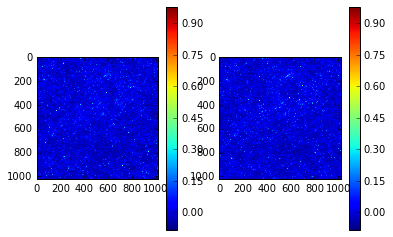

In [11]:
from astropy.io import fits
import matplotlib 
from matplotlib import pyplot as plt

hdulist = fits.open("/global/homes/s/ssingh79/data/fico_0200z_conv_0001.fit")
image = hdulist[0].data

%matplotlib inline
plt.subplot(121)
plt.imshow(image,interpolation='None')
plt.colorbar()
plt.subplot(122)
plt.imshow(image,interpolation='None')
plt.colorbar()


In [3]:
import numpy as np

In [5]:
np.min(image)

-0.082570835947990417

In [18]:
a = np.ones((15,100))
b = np.zeros((1,100))

In [19]:
a = np.vstack((a,b))

In [20]:
a.shape

(16, 100)

In [21]:
c = np.zeros((3,100))

In [22]:
a = np.vstack((a,c))

In [24]:
a.shape

(19, 100)

In [4]:
a =10 
print("a=",a)


a= 10


In [7]:
import sklearn

In [9]:
from sklearn import preprocessing
import numpy as np 



In [5]:
import numpy as np 
m = np.zeros((1, 10))
n = np.ones((5, 10))

p = np.vstack((m,n))
print(p[0])
q = np.delete(p,(0),axis=0)

print(q[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [14]:
q

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [9]:
n

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [3]:
n[0]

NameError: name 'n' is not defined

In [2]:
import cPickle


ImportError: No module named 'cPickle'

In [3]:
import pickle

In [1]:
import numpy as np
A = np.ones((1000,1000000))

In [2]:
A

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [49]:
import h5py
import numpy as np

A = np.random.random((1000,1000))
#with h5py.File('data.h5','w') as hf:
#    hf.create_dataset('dataset',data=A)

#h5py.File('data.h5','w').create_dataset('dataset',data=A)

with h5py.File('data.h5', 'r') as hr:
    print(hr.keys())
    #X = hr['dataset'][0:1000, 0:1000]
    #print(X[1,0:1000])
    
    Y = hr['dataset'][1,:]
    #print(Y)
    print(np.reshape(Y,(100,10)))
    
#hr = h5py.File('data.h5')
#hr.keys()    
          

KeysView(<HDF5 file "data.h5" (mode r)>)
[[ 0.87935668  0.22015663  0.60050923  0.619555    0.36562234  0.01134368
   0.95326378  0.32649935  0.69552117  0.09368583]
 [ 0.9753727   0.81787614  0.14762452  0.79175603  0.22693815  0.97322884
   0.7885924   0.07125317  0.90908325  0.27487283]
 [ 0.51322078  0.92096943  0.85483668  0.58084062  0.09596679  0.03744369
   0.63492219  0.94093238  0.42256708  0.15300893]
 [ 0.37978035  0.28390884  0.72416364  0.48991706  0.66339147  0.75366563
   0.48997917  0.96229903  0.07759361  0.45879281]
 [ 0.48339617  0.30848216  0.6790967   0.40916603  0.24770573  0.49913381
   0.50425874  0.88590725  0.02124993  0.14429764]
 [ 0.26500853  0.91775398  0.38647924  0.31973276  0.85655646  0.05627777
   0.04041011  0.43853301  0.60380474  0.29103324]
 [ 0.40674265  0.21966753  0.0610351   0.48704741  0.5480574   0.40134247
   0.95577665  0.75704035  0.89773579  0.27913323]
 [ 0.55863877  0.41473297  0.53611539  0.60456719  0.09829342  0.39222829
   0.58194

In [5]:
hr.keys()

KeysView(<Closed HDF5 file>)

In [ ]:
import numpy as np
import h5py

B  = np.random.random((1001,1048576))
h5py.File('data.h5','w').create_dataset('dataset',data=B)


In [1]:
close()

NameError: name 'close' is not defined

In [1]:
import h5py


In [6]:
import h5py
import numpy as np

A = np.random.random((1000,1000))
B = np.random.random((1000,1000))

with h5py.File('data1.h5','w') as hf:
    hf.create_dataset('dataset1',data=A[1:10,:])
    hf.create_dataset('dataset2',data=B)




In [7]:
with h5py.File('data1.h5','r') as hf:
    print(hf.keys())
    print(hf['dataset1'][:,:].shape)
    print(hf['dataset2'][:,:])
    

KeysView(<HDF5 file "data1.h5" (mode r)>)
(9, 1000)
[[ 0.74728509  0.94968011  0.75585189 ...,  0.95202549  0.21900725
   0.54665021]
 [ 0.76542339  0.35927125  0.47872476 ...,  0.53334313  0.33448051
   0.46986659]
 [ 0.74337923  0.79785538  0.79103477 ...,  0.53360634  0.05138411
   0.10188293]
 ..., 
 [ 0.97661968  0.16122344  0.38772386 ...,  0.29482163  0.64986342
   0.90160452]
 [ 0.10457696  0.85757524  0.1765187  ...,  0.51944675  0.10324157
   0.83444133]
 [ 0.3509641   0.27396742  0.29322332 ...,  0.95337216  0.38826628
   0.93786058]]


15.6327075958
162
3


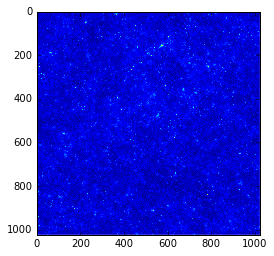

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('/global/homes/s/ssingh79/DeepLearningTutorials-master/code/fico-gifs/fico_0200z_conv_0001.png')
pic = np.array(image)
print(np.mean(pic))
print(np.max(pic))
print(np.min(pic))

%matplotlib inline
plt.imshow(pic, interpolation = 'None')